#### **A Long Short-Term Memory network (LSTM) is a type of deep neural network that is designed to capture historical information of time series data and is suitable for predicting long-term nonlinear series.**
In this project,LSTM was applied to predict Bitcoin prices. By training the model on historical Bitcoin price data, The aim is to forecast future price trends.

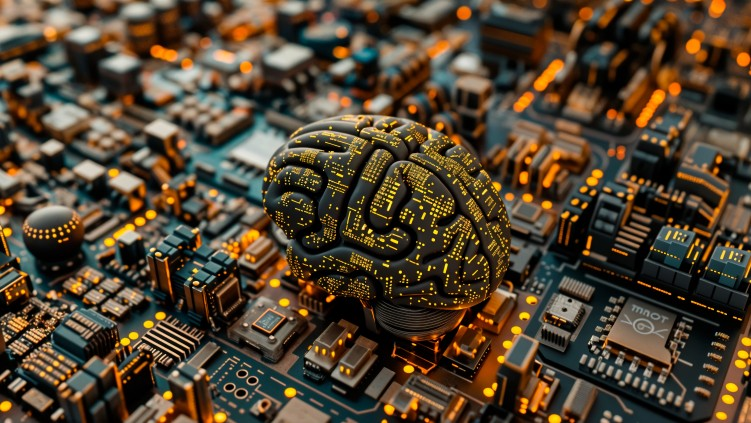

###Import Libraries

In [ ]:
!pip install plotly
import plotly.express as px
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import date, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

###Load Data

In [ ]:
df = pd.read_csv('/content/Bitcoin Historical Data (1).csv')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,10/13/2024,"62,653.2","63,205.4","63,284.6","62,054.2",38.32K,-0.87%
1,10/12/2024,"63,205.1","62,506.6","63,463.1","62,486.1",40.91K,1.13%
2,10/11/2024,"62,499.4","60,317.5","63,385.1","60,080.6",86.38K,3.62%
3,10/10/2024,"60,316.2","60,628.9","61,304.6","59,075.7",83.86K,-0.52%
4,10/09/2024,"60,628.8","62,157.0","62,537.0","60,355.5",68.79K,-2.46%


###Data Preprocessing - Reverse Rows

In [ ]:
# Reverse the rows of the DataFrame
df_fixed = df.iloc[::-1]

# Reset the index to start from 1
df_fixed = df_fixed.reset_index(drop=True)
df_fixed.index = df_fixed.index + 1


In [ ]:
print("Data types of the columns in the data frame:", df_fixed.dtypes)

Data types of the columns in the data frame: Date        object
Price       object
Open        object
High        object
Low         object
Vol.        object
Change %    object
dtype: object


In [ ]:
print("Shape of the data frame:", df_fixed.shape)

Shape of the data frame: (3928, 7)


In [ ]:
print("Information about the data frame:", df_fixed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3928 entries, 1 to 3928
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      3928 non-null   object
 1   Price     3928 non-null   object
 2   Open      3928 non-null   object
 3   High      3928 non-null   object
 4   Low       3928 non-null   object
 5   Vol.      3928 non-null   object
 6   Change %  3928 non-null   object
dtypes: object(7)
memory usage: 214.9+ KB
Information about the data frame: None


In [ ]:
df_fixed.head()

,Date,Price,Open,High,Low,Vol.,Change %
1,01/12/2014,939.8,"1,005.3","1,022.7",922.1,9.93K,-6.52%
2,01/13/2014,922.9,939.8,949.2,879.9,10.13K,-1.80%
3,01/14/2014,919.3,922.9,942.5,904.2,4.31K,-0.39%
4,01/15/2014,941.2,919.3,973.1,915.1,6.83K,2.39%
5,01/16/2014,913.5,941.2,955.5,910.5,5.10K,-2.95%


In [ ]:
df_fixed.tail()

,Date,Price,Open,High,Low,Vol.,Change %
3924,10/09/2024,"60,628.8","62,157.0","62,537.0","60,355.5",68.79K,-2.46%
3925,10/10/2024,"60,316.2","60,628.9","61,304.6","59,075.7",83.86K,-0.52%
3926,10/11/2024,"62,499.4","60,317.5","63,385.1","60,080.6",86.38K,3.62%
3927,10/12/2024,"63,205.1","62,506.6","63,463.1","62,486.1",40.91K,1.13%
3928,10/13/2024,"62,653.2","63,205.4","63,284.6","62,054.2",38.32K,-0.87%


In [ ]:
df_fixed.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [ ]:
len(df_fixed)

3928

### Data Preprocessing - Check Missing Values

In [ ]:
df_fixed.isnull().sum()

,0
Date,0
Price,0
Open,0
High,0
Low,0
Vol.,0
Change %,0


### Data Preprocessing - Extract Dates and Prices

In [ ]:
sd = df_fixed.iloc[0, 0]
ed = df_fixed.iloc[-1, 0]

print('Starting Date', sd)
print('Ending Date', ed)

Starting Date 01/12/2014
Ending Date 10/13/2024


In [ ]:
df_fixed = df_fixed[['Date', 'Price']]
df_fixed

,Date,Price
1,01/12/2014,939.8
2,01/13/2014,922.9
3,01/14/2014,919.3
4,01/15/2014,941.2
5,01/16/2014,913.5
...,...,...
3924,10/09/2024,"60,628.8"
3925,10/10/2024,"60,316.2"
3926,10/11/2024,"62,499.4"
3927,10/12/2024,"63,205.1"


###Data Preprocessing - Clean Prices

In [ ]:
# Extract integer part of 'Price' and convert to numeric
# Remove only the commas and keep the decimal points, then convert to float
df_fixed['Price'] = df_fixed['Price'].str.replace(',', '').astype(float)

# Convert 'Date' column to datetime objects if it's not already
df_fixed['Date'] = pd.to_datetime(df_fixed['Date'])


<ipython-input-14-7269b7df48d2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fixed['Price'] = df_fixed['Price'].str.replace(',', '').astype(float)
<ipython-input-14-7269b7df48d2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fixed['Date'] = pd.to_datetime(df_fixed['Date'])


In [ ]:
df_fixed.dtypes

,0
Date,datetime64[ns]
Price,float64


In [ ]:
df_fixed

,Date,Price
1,2014-01-12,939.8
2,2014-01-13,922.9
3,2014-01-14,919.3
4,2014-01-15,941.2
5,2014-01-16,913.5
...,...,...
3924,2024-10-09,60628.8
3925,2024-10-10,60316.2
3926,2024-10-11,62499.4
3927,2024-10-12,63205.1


### Data Visualization

In [ ]:
fig = px.line(df_fixed, x='Date', y='Price', title='BTC Price')

# Customize the plot
fig.update_traces(mode='lines', marker=dict(size=8))  # Add markers to the lines
fig.update_layout(xaxis_title='Date', yaxis_title='Price')  # Update axis labels
fig.update_xaxes(tickangle=45, tickformat="%b %Y")  # Rotate and format x-axis labels
# Customize the plot to prevent the price from being formatted with "K"
fig.update_layout(
    yaxis=dict(
        tickformat=".2f"  # This forces two decimal places without any abbreviations like 'K'
    )
)
# Show the plot
fig.show()

###Data Preprocessing

---


* Prepare for Machine Learning
* Scale Data
* Split Data into Train and Test Sets

In [ ]:
# 1. Load and Preprocess the Data
data = df_fixed[['Price']].values

# 2. Scale the Data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# 3. Split Data into Train and Test Sets
train_size = int(len(data) * 0.8)
train_data, test_data = data[0:train_size,:], data[train_size:len(data),:]

In [ ]:
# 4. Create the Dataset
look_back = 60  # Number of previous days to consider

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, Y_train = create_dataset(train_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# 5. Reshape the Input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Build and Train the LSTM Model

In [ ]:
# 6. Build and Train the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units = 50))

# Adding the output layer
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, Y_train, epochs=100, batch_size=32)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Epoch 1/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.0099
Epoch 2/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 7.2566e-04
Epoch 3/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.2832e-04
Epoch 4/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.1067e-04
Epoch 5/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 4.5236e-04
Epoch 6/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.9864e-04
Epoch 7/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.5583e-04
Epoch 8/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.7276e-04
Epoch 9/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.8383e-04
Epoch 10/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.6571e-04
Epoch 11/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.2757e-04
Epoch 12/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5185e-04
Epoch 13/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1038e-04
Epoch 14/100
97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 2.3450e-04
Epoch 15/100


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 91,955 (359.20 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 61,304 (239.47 KB)

 ### Make Predictions and Plotting Results

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


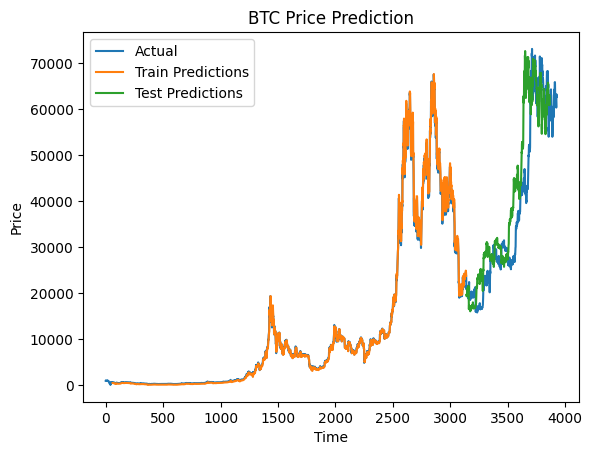

In [ ]:
# 7. Make Predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# 8. Invert Predictions to Original Scale
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform(Y_train.reshape(-1, 1))  # Reshape Y_train for inverse_transform
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform(Y_test.reshape(-1, 1))  # Reshape Y_test for inverse_transform

# 9. Plot the Results
plt.plot(scaler.inverse_transform(data), label='Actual')  # Plot actual prices
plt.plot(np.concatenate([np.full(look_back, np.nan), train_predict[:,0]]), label='Train Predictions')  # Plot train predictions
plt.plot(np.concatenate([np.full(len(train_predict) + look_back, np.nan), test_predict[:,0]]), label='Test Predictions')  # Plot test predictions
plt.legend()
plt.title('BTC Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()



###Evaluate Model Performance

In [ ]:
# Calculate the absolute differences between actual and predicted values
errors = np.abs(Y_test - test_predict)

# Calculate the percentage error
percentage_errors = (errors / Y_test) * 100

# Calculate the mean percentage error
mean_percentage_error = np.mean(percentage_errors)

print(f"Error Percentage: {mean_percentage_error:.2f}%")

Error Percentage: 2.20%


In [ ]:
rmse = np.sqrt(mean_squared_error(Y_test, test_predict))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 1225.170


###Predict Future Prices

In [ ]:

# 10. Predict the next 7 days
# Prepare the last 'look_back' days of data for prediction
last_days = data[-look_back:]
last_days = np.reshape(last_days, (1, last_days.shape[0], 1))

# Predict the next 7 days
next_7_days_prediction = []
for _ in range(7):
    next_day_prediction = model.predict(last_days)
    next_7_days_prediction.append(next_day_prediction[0, 0])  # Append the predicted value
    # Fix: Remove extra brackets and reshape next_day_prediction
    last_days = np.append(last_days[:, 1:, :], next_day_prediction.reshape(1, 1, 1), axis=1) # Update last_days with the prediction

# Inverse transform the predictions back to original scale
next_7_days_prediction = scaler.inverse_transform(np.array(next_7_days_prediction).reshape(-1, 1))


# Generate future dates for the next 7 days starting from the last date in df_fixed
last_date_in_df = pd.to_datetime(df_fixed['Date'].iloc[-1]) # Get the last date from df_fixed
future_dates = [last_date_in_df + timedelta(days=i) for i in range(1, 8)] # Generate next 7 dates

# Create a DataFrame for the predicted prices and dates
predicted_df = pd.DataFrame({
    'Date': future_dates,
    'Price': next_7_days_prediction.flatten()
})
# Print the DataFrame
print(predicted_df)

# Optional: Visualize using Plotly
fig_predicted = px.line(predicted_df, x='Date', y='Price', title='Predicted BTC Price for the Next 7 Days')
fig_predicted.update_traces(mode='lines+markers')  # Add markers to the lines
fig_predicted.update_layout(xaxis_title='Date', yaxis_title='Price')
fig_predicted.update_xaxes(tickangle=45, tickformat="%b %d") # More specific date format
fig_predicted.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
        Date         Price
0 2024-10-14  63006.507812
1 2024-10-15  63402.597656
2 2024-10-16  63713.902344
3 2024-10-17  64000.671875
4 2024-10-18  64261.101562
5 2024-10-19  64491.718750
6 2024-10-20  64691.839844


### Plot Past and Future Predictions

In [ ]:

# Prepare data for plotting
last_3_months = df_fixed.tail(90) # Last 3 months data
future_dates = pd.date_range(start=df_fixed['Date'].iloc[-1], periods=8)[1:]

# Create a DataFrame for the predicted values
future_df = pd.DataFrame({'Date': future_dates, 'Price': next_7_days_prediction.flatten()})

# Combine actual and predicted data for the last three months and the next 7 days
combined_df = pd.concat([last_3_months, future_df], ignore_index=True)

# Prepare data for the last three months
last_3_months_data = df_fixed.tail(90)

# Generate future dates for prediction (next 7 days)
future_dates = pd.date_range(start=df_fixed['Date'].iloc[-1], periods=8)[1:]

# Predict the next 7 days
last_days = data[-look_back:].reshape(1, look_back, 1)  # Reshape for prediction
next_7_days_prediction = [model.predict(last_days)[0, 0]]  # Get the first prediction
for _ in range(6):  # Predict the remaining 6 days
    last_days = np.append(last_days[:, 1:, :], [[[next_7_days_prediction[-1]]]], axis=1)
    next_7_days_prediction.append(model.predict(last_days)[0, 0])
next_7_days_prediction = scaler.inverse_transform(np.array(next_7_days_prediction).reshape(-1, 1))

# Create a DataFrame for predicted values
future_df = pd.DataFrame({'Date': future_dates, 'Price': next_7_days_prediction.flatten()})

# Combine actual and predicted data for the last two months and the next 7 days
combined_df = pd.concat([last_3_months_data, future_df], ignore_index=True)

# Create traces for actual, predicted, and test data
fig = go.Figure()

# Actual data for the last two months
fig.add_trace(go.Scatter(x=last_3_months_data['Date'], y=last_3_months_data['Price'],
                         mode='lines', name='Actual', line=dict(color='salmon')))

# Test predictions for the last two months
test_dates = df_fixed['Date'][train_size + look_back + 1:train_size + len(Y_test) + look_back + 1]
test_dates_3_months = test_dates[test_dates >= last_3_months_data['Date'].iloc[0]]
Y_test_3_months = Y_test[test_dates.isin(test_dates_3_months)]
fig.add_trace(go.Scatter(x=test_dates_3_months, y=Y_test_3_months.flatten(),
                         mode='lines', name='Model Predictions', line=dict(color='green')))

# Predicted data for the next 7 days
fig.add_trace(go.Scatter(x=future_df['Date'], y=future_df['Price'],
                         mode='lines', name='Future Predictions', line=dict(color='red')))

# Customize the plot to prevent the price from being formatted with "K"
fig.update_layout(
    yaxis=dict(
        tickformat=".2f"  # This forces two decimal places without any abbreviations like 'K'
    )
)

fig.update_layout(title='BTC Price - Actual vs. Predicted vs. Test (Last 3 Months)',
                  xaxis_title='Date', yaxis_title='Price', template='plotly_white',
                  xaxis_rangeslider_visible=False)  # Remove the range slider
fig.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


### Comparing the Predicted prices with the Actual data

In [ ]:
# Create a DataFrame for the actual data
actual_data = {
    'Date': pd.to_datetime(['2024-10-14', '2024-10-15', '2024-10-16', '2024-10-17', '2024-10-18', '2024-10-19', '2024-10-20']),
    'Price': [66046.13, 67041.11, 67612.72, 67399.84, 68418.79, 68362.73, 69001.70]
}
actual_df = pd.DataFrame(actual_data)

# Merge the actual and predicted dataframes
merged_df = pd.merge(actual_df, predicted_df, on='Date', suffixes=('_actual', '_predicted'))

fig = go.Figure()

# Add the actual data
fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Price_actual'],
                         mode='lines+markers', name='Actual Price', line=dict(color='blue')))
# Add the predicted data
fig.add_trace(go.Scatter(x=merged_df['Date'], y=merged_df['Price_predicted'],
                         mode='lines+markers', name='Predicted Price', line=dict(color='red')))

fig.update_layout(
    title='BTC Price - Actual vs. Predicted (October 14-20, 2024)',
    xaxis_title='Date',
    yaxis_title='Price',
    xaxis_tickformat = '%Y-%m-%d',
    template='plotly_white'
)

fig.show()